In [1]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

# %matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display
from gammapy.data import Observation, observatory_locations
from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff
from gammapy.estimators import SensitivityEstimator
from gammapy.irf import load_cta_irfs
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom

In [3]:
from gammapy.utils.check import check_tutorials_setup

check_tutorials_setup()


System:

	python_executable      : /home/savchenk/miniconda-recent/envs/gammapy-1.0.1/bin/python 
	python_version         : 3.9.16     
	machine                : x86_64     
	system                 : Linux      


Gammapy package:

	version                : 1.0.1      
	path                   : /home/savchenk/miniconda-recent/envs/gammapy-1.0.1/lib/python3.9/site-packages/gammapy 


Other packages:

	numpy                  : 1.24.2     
	scipy                  : 1.10.1     
	astropy                : 5.1.1      
	regions                : 0.7        
	click                  : 8.1.3      
	yaml                   : 6.0        
	IPython                : 8.7.0      
	jupyterlab             : 3.5.3      
	matplotlib             : 3.7.1      
	pandas                 : 1.5.2      
	healpy                 : 1.16.1     
	iminuit                : 2.20.0     
	sherpa                 : 4.15.0     
	naima                  : 0.10.0     
	emcee                  : 3.1.3      
	corner                 : 

In [4]:
energy_axis = MapAxis.from_energy_bounds("0.03 TeV", "30 TeV", nbin=20)
energy_axis_true = MapAxis.from_energy_bounds(
    "0.01 TeV", "100 TeV", nbin=100, name="energy_true"
)

geom = RegionGeom.create("icrs;circle(0, 0.5, 0.1)", axes=[energy_axis])

empty_dataset = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

In [5]:
irfs = load_cta_irfs(
    # "$GAMMAPY_DATA/1.0/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits",
    "./Prod5-South-20deg-SouthAz-14MSTs37SSTs.18000s-v0.1.fits.gz"
    # "$GAMMAPY_DATA/1.0/cta-caldb/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz"
)
location = observatory_locations["cta_south"]
pointing = SkyCoord("0 deg", "0 deg")
obs = Observation.create(
    pointing=pointing, irfs=irfs, livetime="50 h", location=location
)

spectrum_maker = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])
dataset = spectrum_maker.run(empty_dataset, obs)

In [6]:
containment = 0.68

# correct exposure
dataset.exposure *= containment

# correct background estimation
on_radii = obs.psf.containment_radius(
    energy_true=energy_axis.center, offset=0.5 * u.deg, fraction=containment
)
factor = (1 - np.cos(on_radii)) / (1 - np.cos(geom.region.radius))
dataset.background *= factor.value.reshape((-1, 1, 1))


In [7]:
dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, acceptance=1, acceptance_off=5
)

In [13]:
sensitivity_estimator = SensitivityEstimator(
    gamma_min=10, n_sigma=5, bkg_syst_fraction=0.10
)
sensitivity_table = sensitivity_estimator.run(dataset_on_off)

In [9]:
emin_cta, flux_cta = np.loadtxt('CTA_point_source_left.txt',unpack=True) # E[TeV], E^2 * Flux Sensitivity [erg cm^2/s]
emax_cta, flux_cta = np.loadtxt('CTA_point_source_right.txt',unpack=True)
emean_cta, flux_cta = np.loadtxt('CTA_point_source_mean.txt',unpack=True)

In [10]:
# check this out, data for 
# https://zenodo.org/record/5499840#.YUya5WYzbUI
# https://docs.gammapy.org/1.0.1/tutorials/analysis-1d/cta_sensitivity.html?highlight=sensitivity

energy,e2dnde,excess,background,criterion
TeV,erg / (cm2 s),,,
float64,float64,float64,float64,bytes12
0.0356551,5.64402e-10,2763.51,27635.1,bkg
0.0503641,1.7937e-11,1546.72,15467.2,bkg
0.0711412,4.41506e-12,1774.13,17741.3,bkg
0.10049,2.05823e-12,1071.5,10715,bkg
0.141945,9.81884e-13,397.618,3976.18,bkg
0.200503,6.21084e-13,209.072,1377.14,significance
0.283218,4.36583e-13,133.553,544.013,significance
0.400056,3.37873e-13,89.9864,236.309,significance


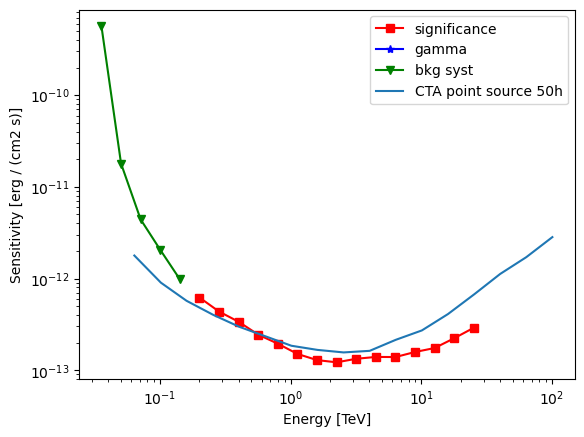

In [11]:
# Show the results table
display(sensitivity_table)

# Save it to file (could use e.g. format of CSV or ECSV or FITS)
# sensitivity_table.write('sensitivity.ecsv', format='ascii.ecsv')

# Plot the sensitivity curve
t = sensitivity_table

is_s = t["criterion"] == "significance"

fig, ax = plt.subplots()
ax.plot(
    t["energy"][is_s],
    t["e2dnde"][is_s],
    "s-",
    color="red",
    label="significance",
)

is_g = t["criterion"] == "gamma"
ax.plot(t["energy"][is_g], t["e2dnde"][is_g], "*-", color="blue", label="gamma")
is_bkg_syst = t["criterion"] == "bkg"
ax.plot(
    t["energy"][is_bkg_syst],
    t["e2dnde"][is_bkg_syst],
    "v-",
    color="green",
    label="bkg syst",
)

plt.errorbar(emean_cta[2:-1],flux_cta[2:-1],label='CTA point source 50h')


ax.loglog()
ax.set_xlabel(f"Energy [{t['energy'].unit}]")
ax.set_ylabel(f"Sensitivity [{t['e2dnde'].unit}]")
ax.legend()

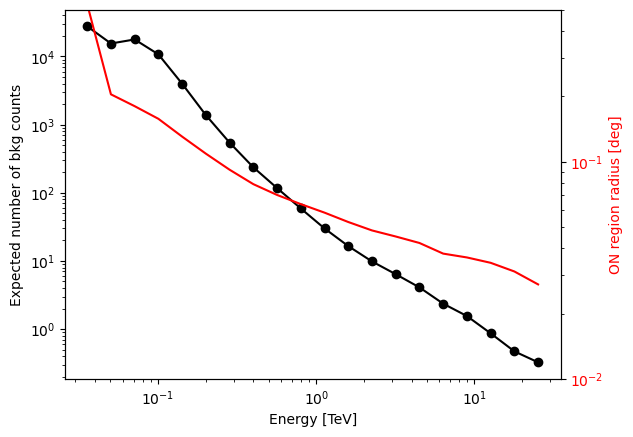

In [12]:
# Plot expected number of counts for signal and background
fig, ax1 = plt.subplots()
# ax1.plot( t["energy"], t["excess"],"o-", color="red", label="signal")
ax1.plot(t["energy"], t["background"], "o-", color="black", label="blackground")

ax1.loglog()
ax1.set_xlabel(f"Energy [{t['energy'].unit}]")
ax1.set_ylabel("Expected number of bkg counts")

ax2 = ax1.twinx()
ax2.set_ylabel(f"ON region radius [{on_radii.unit}]", color="red")
ax2.semilogy(t["energy"], on_radii, color="red", label="PSF68")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0.01, 0.5)
plt.show()